# <div style="text-align: center; margin-top:2em; margin-bottom:1em">ESTADÍSTICA PARA INGENIERÍA Y CIENCIAS</div>
## <div style="text-align: center;">TRABAJO FINAL:</div>
## <div style="text-align: center; margin-bottom:1em">Mediciones sobre un motor síncrono de imán permanente</div>
## <div style="text-align: center; margin-bottom:1em">Ivan Svetlich</div>

***
<br></br>

In [64]:
#Librerias
library(IRdisplay)
library(formattable)
library(ggplot2)
library(cowplot)
library(dplyr)
library(stringr)
library(Hmisc)
library(data.table)
library(flextable)
library(kableExtra)
library(olsrr)
library(caTools)
library(gridExtra)
library(ggcorrplot)
library(MLmetrics)
library(yardstick)

<br></br>

## **Introducción**

<div style="text-align: justify">El motor síncrono de imán permanente (PMSM) es un motor síncrono de corriente alterna cuya excitación de campo proviene de imanes permanentes, y que tiene una forma de onda de fuerza contraelectromotriz senoidal. Como con los motores de corriente continua sin escobillas, tiene un rotor de imán permanente y bobinas en el estator. Sin embargo, la estructura del estator con bobinas construidas para producir una densidad de flujo senoidal en el vacío de aire de la máquina se parece a la de un motor de inducción. Su densidad de potencia es mayor que la de los motores de inducción en los mismos rangos, ya que no cuenta con potencia del estator dedicada a la producción de campos magnéticos.</div>

<div style="text-align: justify">Los PMSM se utilizan generalmente para controladores de motor de alto rendimiento y alta eficiencia. El control de motores de alto rendimiento se caracteriza por una rotación uniforme en todo el rango de velocidad del motor, control total de par motor a velocidad cero y aceleración y desaceleración rápidas.</div>

<div style="text-align: justify">Hoy en día, el PMSM es el motor elegido en la mayoría de los diseños de vehículos eléctricos e híbridos en el mercado.</div>

***
<br></br>

<br></br>

## **Dataset**

<div style="text-align: justify">El dataset comprende lecturas de varios sensores aplicados a un motor síncrono de imanes permanentes (PMSM) desplegado en un banco de pruebas. Las mediciones fueron recopiladas por el departamento de <i>Electrónica de Potencia y Accionamientos Eléctricos</i> de la <i>Universidad de Paderborn</i>, Alemania.</div>

<div style="text-align: justify">La temperatura del rotor es un parámetro especialmente difícil de obtener en un vehículo comercial, tanto desde el punto de vista de la confiabilidad de la medición como del costo económico implicado. En el presente informe se intenta desarrollar un modelo de regresión lineal múltiple que permita predecir la temperatura del imán permanente del rotor a partir de otros parámetros de funcionamiento.</div>

In [4]:
pmsm_data <- read.csv("./tp_final_data.csv") # Leo los datos desde archivo .csv (puede tardar bastante tiempo)

<div style="text-align: justify">El dataset está compuesto por 13 variables (columnas) y un total de 1330816 observaciones (filas). Todas las variables son numéricas y no hay datos faltantes en ninguna de ellas.</div>

In [224]:
round(head(pmsm_data),2) %>% kable("html", table.attr = "style='width:100%;'") %>%  as.character() %>% display_html()

u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
-0.45,18.81,19.09,-0.35,18.29,0.00,0.00,0.00,24.55,18.32,19.85,0.19,17
-0.33,18.82,19.09,-0.31,18.29,0.00,0.00,0.00,24.54,18.31,19.85,0.25,17
-0.44,18.83,19.09,-0.37,18.29,0.00,0.00,0.00,24.54,18.33,19.85,0.18,17
-0.33,18.84,19.08,-0.32,18.29,0.01,0.00,0.00,24.55,18.33,19.85,0.24,17
-0.47,18.86,19.08,-0.33,18.29,0.00,-0.06,0.04,24.57,18.33,19.85,0.21,17
-0.54,18.90,19.08,0.01,18.29,0.01,-0.61,0.34,24.57,18.32,19.85,0.48,17


#### <b>Columnas</b>:

<ul sty>
    <li><b>u_q</b>: tensión en cuadratura - Volts (V)</li>
    <li><b>coolant</b>: temperatura del refrigerante - ºC</li>
    <li><b>stator_winding</b>: temperatura del devanado del estator - ºC</li>
    <li><b>u_d</b>: tensión directa - Volts (V)</li>
    <li><b>stator_tooth</b>: temperatura del diente del estator - ºC</li>
    <li><b>motor_speed</b>: velocidad del motor - rpm</li>
    <li><b>i_d</b>: corriente directa - Ampers (A)</li>
    <li><b>i_q</b>: corriente en cuadratura - Ampers (A)</li>
    <li><b>pm</b>: temperatura del imán permanente (rotor) - ºC</li>
    <li><b>stator_yoke</b>: temperatura de la carcasa - ºC</li>
    <li><b>ambient</b>: temperatura ambiente - ºC</li>
    <li><b>torque</b>: torque del motor - Nm</li>
    <li><b>profile_id</b>: id de la medición</li>
</ul>

<br></br>

## **Preparación de los datos**

<div style="text-align: justify">El dataset está compuesto por 1330816 lecturas. Una cantidad tan grande de datos implica costos computacionales altos y provoca lentitud en algunas operaciones. Por eso, se hace un muestreo aleatorio para trabajar con el 10% de las lecturas.</div>

In [79]:
pmsm_data.sample <- pmsm_data %>% dplyr::sample_frac(.10)
display_markdown(sprintf("10%% de %d . . . . . %d filas", nrow(pmsm_data), nrow(pmsm_data.sample)))

10% de 1330816 . . . . . 133082 filas

<div style="text-align: justify">Algunas de las columnas no son de interés en este análisis. En primer lugar, la columna <b>profile_id</b> no aporta información relevante y puede ser descartada:</div>

In [80]:
pmsm_data.sample1 <- pmsm_data.sample %>% select(-profile_id)

<div style="text-align: justify">Si bien el torque del motor es un parámetro relevante, su medición no es sencilla. Al igual que la temperatura del rotor, resulta difícil de obtener en un vehículo comercial desde un punto de vista práctico. Por lo tanto, también se remueve la columna <b>torque</b>:</div>

In [81]:
pmsm_data.sample2 <- pmsm_data.sample1 %>% select(-torque)

<div style="text-align: justify">Las tensiones y corrientes medidas toman valores tanto positivos como negativos. Analizando la posible relación de estos parámetros con la temperatura del rotor, es razonable asumir que la magnitud de la lectura sea una variable relevante para el modelo, independientemente del signo. Por eso se utilizan los valores absolutos de las columnas <b>u_d</b>, <b>u_q</b>, <b>i_d</b> y <b>i_q</b>:</div>

In [82]:
pmsm_data.sample3 <- pmsm_data.sample2 %>% mutate(
    u_d = abs(u_d),
    u_q = abs(u_q),
    i_d = abs(i_d),
    i_q = abs(i_q))

<div style="text-align: justify">Con el fin de poder evaluar posteriormente la calidad predictiva del modelo, se dividen los datos en dos subconjuntos:</div>
<ul>
    <li>Un subconjunto <b>pmsm_data.train</b> que se utilizará para ajustar el modelo.</li>
    <li>Otro subconjunto <b>pmsm_data.test</b> sobre el cual se aplicará el modelo para intentar predecir la variable de interés.</li>
</ul>

In [9]:
pmsm_data.sample4 <- pmsm_data.sample3 %>% mutate(ID = row_number())
pmsm_data.train <- pmsm_data.sample4 %>% sample_frac(.70)
pmsm_data.test <- pmsm_data.sample4 %>% anti_join(pmsm_data.train, by = 'ID')

***
<br></br>

<br></br>

## **Selección del modelo**

<div style="text-align: justify">El modelo de regresión lineal propuesto utiliza todas las variables resultantes de las transformaciones realizadas en la sección anterior, siendo <b>pm</b> (temperatura del imán en el rotor) la variable dependiente que se busca predecir.</div>

<div style="text-align: justify; font-size: larger">$$y = \beta_0 + \beta_1x_1 + \ldots + \beta_{10}x_{10}$$</div>

In [17]:
model <- lm(pm ~ . -ID, pmsm_data.train)
summary(model)


Call:
lm(formula = pm ~ . - ID, data = pmsm_data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.343  -4.653  -0.470   3.964  39.873 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.720e+01  3.511e-01  -48.99   <2e-16 ***
u_q            -1.195e-01  1.710e-03  -69.87   <2e-16 ***
coolant        -1.808e-01  7.404e-03  -24.42   <2e-16 ***
stator_winding -1.605e+00  1.201e-02 -133.65   <2e-16 ***
u_d             2.098e-02  1.078e-03   19.46   <2e-16 ***
stator_tooth    4.016e+00  2.890e-02  138.97   <2e-16 ***
motor_speed     2.234e-03  7.242e-05   30.84   <2e-16 ***
i_d            -3.107e-02  1.657e-03  -18.75   <2e-16 ***
i_q            -1.383e-02  8.414e-04  -16.44   <2e-16 ***
stator_yoke    -1.622e+00  2.566e-02  -63.24   <2e-16 ***
ambient         1.717e+00  1.559e-02  110.11   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.28 on 93146 degrees of freedom
Multiple R-s

<div style="text-align: justify"><strong>Significancia de la regresión (estadístico F)</strong></div>

<div style="text-align: justify">Para probar la validez del modelo, se utiliza la hipótesis nuela de que la variable respuesta no puede ser representada como una función de ninguna de las variables regresoras.</div>

<div style="text-align: justify; font-size: larger">$$H_0:\beta_0 = \beta_1 = \ldots = \beta_{10} = 0$$</div>

<div style="text-align: justify">Esta hipótesis puede probarse usando el estadístico F, que se calcula con la siguiente fórmula:</div>

<div style="text-align: justify; font-size: larger">$$f = \frac{MSR}{MSE}$$</div>

<div style="text-align: justify">El valor del estadístico F es $5.397e+04$, con 10 y 93146 grados de libertad, arrojando un p-valor de $2.2e-16 \approx 0$. Con este resultado se rechaza la hipótesis nula.</div>

<div style="text-align: justify"><strong>Bondad de ajuste (estadístico $R^2$)</strong></div>

<div style="text-align: justify"> El estadístico $R^2$ representa la proporción de la varianza de la variable respuesta que es explicada por las variables predictoras del modelo de regresión. </div>

<div style="text-align: justify; front-size: larger;">$$R^2 = 1 - \frac{SSE}{SST}$$</div>

<div style="text-align: justify"> El valor del estadístico $R^2$ para el modelo propuesto es $0.8528$. Calificar el valor del estádistico como "bueno" va a depender del área de estudio y de las necesidades específicas del problema. En este caso, se puede concluir que el resultado obtenido es aceptable para el contexto de la prueba.</div>

<div style="text-align: justify"><strong>Evaluando otros modelos</strong></div>

<div style="text-align: justify"> Si bien el modelo planteado utiliza todas las variables disponibles, existe la posibilidad de que un modelo con menor número de variables tenga un mejor desempeño. A continuación se realiza una comparación por pasos (agregando una nueva variable en cada paso) de los distintos modelos posibles. El criterio de evaluación seleccionado es el $R^2$.</div>

In [201]:
k <- ols_step_best_subset(model)

In [223]:
k[sort.list(k$rsquare, decreasing=TRUE),] %>% mutate_if(is.numeric, round, digits=3) %>% select(n, predictors, rsquare, adjr, aic) %>% kable("html") %>%  as.character() %>% display_html()

,n,predictors,rsquare,adjr,aic
1023,10,u_q coolant stator_winding u_d stator_tooth motor_speed i_d i_q stator_yoke ambient,0.853,0.853,634210.5
1015,9,u_q coolant stator_winding u_d stator_tooth motor_speed i_d stator_yoke ambient,0.853,0.853,634315.3
998,8,u_q stator_winding u_d stator_tooth motor_speed i_d stator_yoke ambient,0.852,0.852,634917.5
921,7,u_q stator_winding stator_tooth motor_speed i_d stator_yoke ambient,0.851,0.851,635861.7
733,6,u_q stator_winding stator_tooth motor_speed stator_yoke ambient,0.849,0.849,637149.9
466,5,u_q stator_winding stator_tooth stator_yoke ambient,0.843,0.843,640834.3
213,4,u_q stator_winding stator_tooth stator_yoke,0.826,0.826,650363.9
129,3,stator_winding stator_tooth stator_yoke,0.806,0.806,660189.2
45,2,stator_tooth ambient,0.718,0.718,695279.2
5,1,stator_tooth,0.692,0.692,703267.1


<div style="text-align: justify">El modelo con mayor $R^2$ es el que incluye tadas las variables. Cabe aclarar que el $R^2$ tiende a incrementar a medida que se agregan variables al modelo. Otros criterios, como el AIC, tienen en cuenta la simplicidad del modelo (cantidad de variables regresoras) en su fórmula.</div>

<br></br>

## **Predicción y evaluación de desempeño**

<div style="text-align: justify">Con el fin de evaluar las capacidades predictivas del modelo propuesto, se intenta predecir los valores de temperatura del rotor para el subconjunto de datos <b>pmsm_data.test</b> y se compara los resultados obtenidos con los valores reales.</div>

In [53]:
pm.predict <- predict (model, pmsm_data.test)

<div style="text-align: justify">El criterio de evaluación utlizado es el error porcentual medio $\left(\text{MPE}\right)$ entre las temperaturas predichas y las relevadas en el experimento. Un valor de error cuadrático medio cercano a cero significa un buen desempeño del modelo.</div>

<div style="text-align: justify; font-size: larger">$$\text{MPE} = \frac{100\%}{n} \sum_{t=1}^{n} \frac{a_t - f_t}{a_t}$$</div>

<div style="text-align: justify">donde $a_t$ es el valor real, $f_t$ es el valor estimado y $n$ es el número de predicciones realizadas.</div>

In [71]:
df <- data.frame(truth=pmsm_data.test$pm, estimate=y.predict)
mpe(df, truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mpe,standard,-2.113116


<div style="text-align: justify">El MPE es $-2.113116$, lo que significa que el modelo es capaz de predecir la temperatura del imán en el rotor con un error promedio de aproximadamente $2\%$.</div>

<br></br>

### **Análisis de residuos**

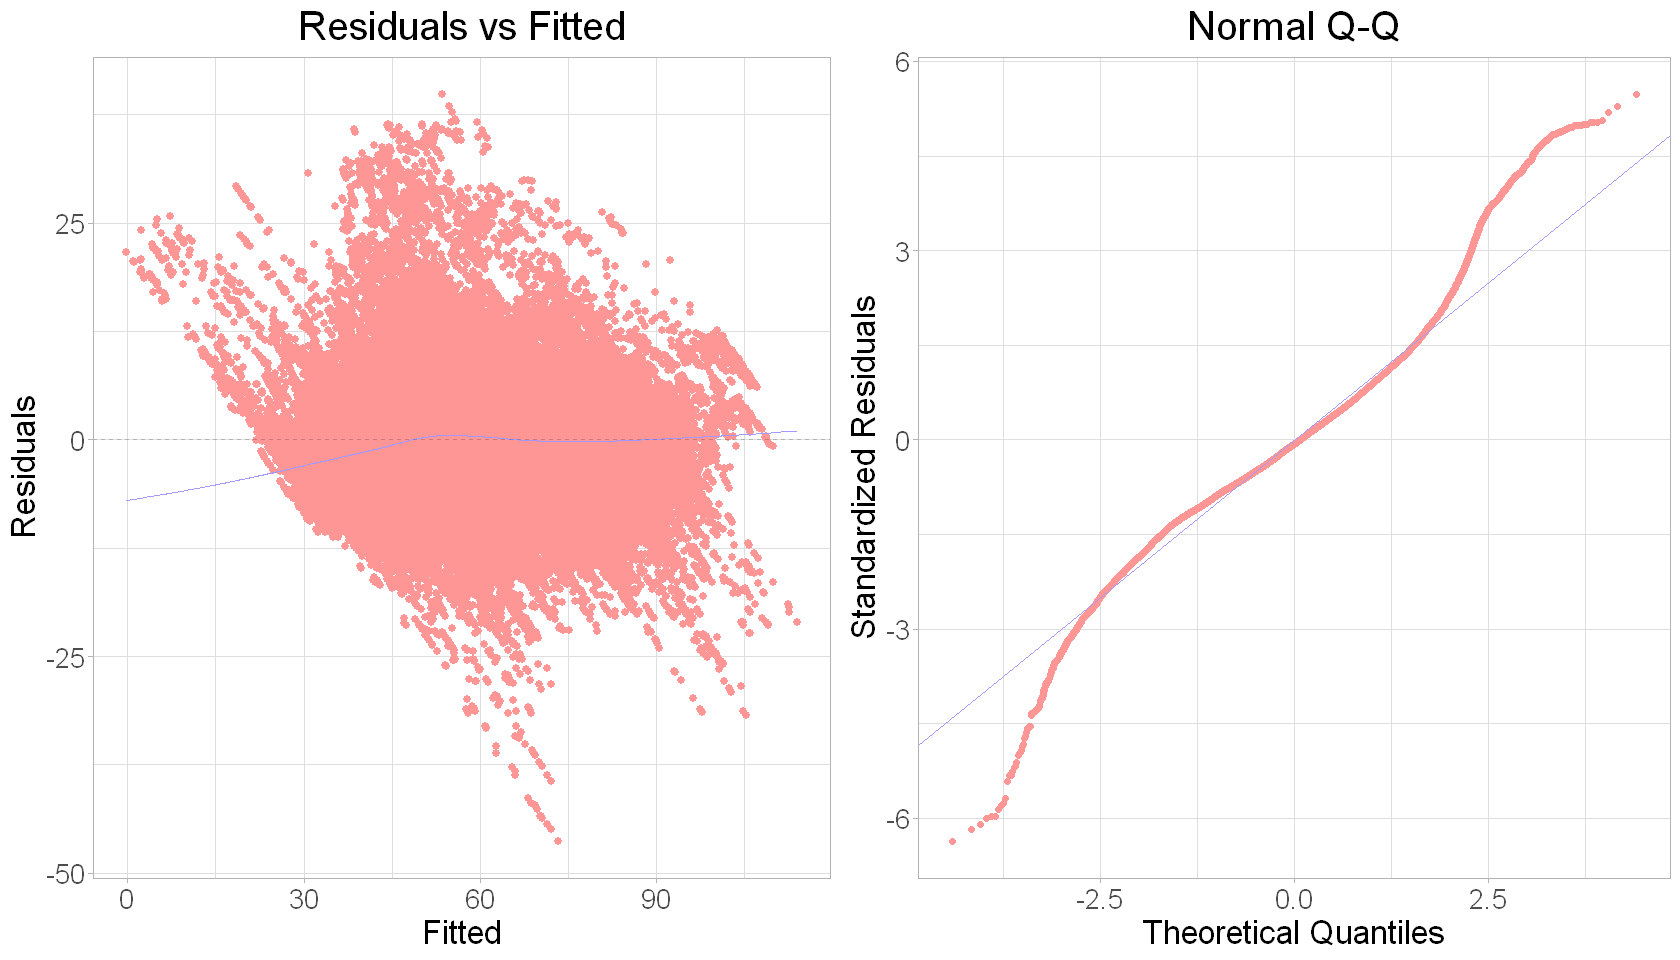

In [225]:
# Gráficos
options(repr.plot.width=14, repr.plot.height=8)
res_vs_fit <- ggplot(model) + 
    geom_point(aes(x=model$fitted, y=model$residuals), color= '#ff9696', size=2) +
    geom_path(data = smoothed, aes(x = x, y = y), col="#a399ff") +
    geom_hline(linetype = 2, yintercept=0, alpha=0.2) +
    ggtitle("Residuals vs Fitted") +
    xlab("Fitted") +
    ylab("Residuals") +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

qq_plot <- ggplot(model) +
    stat_qq(aes(sample = .stdresid), color= '#ff9696') +
    geom_abline(col="#a399ff") +
    xlab("Theoretical Quantiles") +
    ylab("Standardized Residuals") +
    ggtitle("Normal Q-Q") +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

plot_grid(res_vs_fit, qq_plot, ncol = 2)


<div style="text-align: justify">
    <b>Análisis de residuos</b>
    <ul>
        <li>La gráfica de <i style="color: blue">Residuos vs. Valores Ajustados</i> no presenta evidencias fuertes contra el supuesto de varianza constante.</li>
        <li>Los valores en la gráfica de <i style="color: red">Probabilidad Normal</i> presentan una forma de <b>S invertida</b>, lo cual sugiere que los datos provienen de una distribución que presenta mayor dispersión respecto de la distribución normal.</li>
    </ul>
</div>

***
<br></br>

<br></br>

## **Modelos adicionales**

<div style="text-align: justify">Otra pregunta interesante es si es posible predecir la velocidad del motor a partir de otros parámetros de funcionamiento. En esta sección se plantean diversos modelos de regresión y se evaluan los cambios en el desempeño cuando se agregan nuevas variables y términos de interacción.</div>

<br></br>

#### <div style="text-align: justify"><strong>a. Una variable regresora</strong></div>

<div style="text-align: justify">En primer lugar, se propone un modelo simple con el <b>valor absoluto de la tensión en cuadratura (u_q)</b> como única variable regresora:</div>

<div style="text-align: justify; font-size: larger">$$y = \beta_0 + \beta_1u_q$$</div>

In [117]:
model_speed.1 <- lm(motor_speed ~ u_q, pmsm_data.train)
summary(model_speed.1)


Call:
lm(formula = motor_speed ~ u_q, data = pmsm_data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1674.1  -825.8  -624.7   578.0  4943.0 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 644.0491     7.0417   91.46   <2e-16 ***
u_q          28.7990     0.1009  285.35   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1360 on 93155 degrees of freedom
Multiple R-squared:  0.4664,	Adjusted R-squared:  0.4664 
F-statistic: 8.142e+04 on 1 and 93155 DF,  p-value: < 2.2e-16


<div style="text-align: justify">El $R^2$ obtenido es de $0.4664$, lo cual indica que el ajuste de este modelo no es bueno.</div>

<br></br>

#### <div style="text-align: justify"><strong>b. Dos variables regresoras</strong></div>

<div style="text-align: justify">El siguiente modelo agrega el <b>valor absoluto de la tensión directa (u_d)</b>:</div>

<div style="text-align: justify; font-size: larger">$$y = \beta_0 + \beta_1 u_q + \beta_{2} u_d$$</div>

In [119]:
model_speed.2 <- lm(motor_speed ~ u_q + u_d, pmsm_data.train)
summary(model_speed.2)


Call:
lm(formula = motor_speed ~ u_q + u_d, data = pmsm_data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1803.8  -800.5  -431.1   729.9  5594.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 428.81979    6.66904    64.3   <2e-16 ***
u_q          28.86907    0.09267   311.5   <2e-16 ***
u_d          -8.51431    0.06466  -131.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1249 on 93154 degrees of freedom
Multiple R-squared:  0.5501,	Adjusted R-squared:  0.5501 
F-statistic: 5.696e+04 on 2 and 93154 DF,  p-value: < 2.2e-16


<div style="text-align: justify">El nuevo término consiguió un incremento en el $R^2$ $\left(0.5501 \text{ vs } 0.4664\right)$. Si bien el valor sigue siendo bajo, la mejora en el ajuste no es despreciable.</div>

#### <div style="text-align: justify"><strong>Suma adicional de cuadrados</strong></div>


<div style="text-align: justify">Para determinar si el término agregado tiene un aporte significativo al modelo, se puede probar la hipótesis $H_0: \beta_{11} = 0$. De esta forma se contrasta el modelo completo $\left(MC\right)$ con un modelo reducido que no contiene el término cuadrático $\left(MR\right)$. El estadístico utilizado es:</div>

#### <div style="text-align: center">$$F_0 = \frac{\left(SSE_{MR} - SSE_{MC}\right) / \left(k - r\right)}{SSE_{MC} / \left(n - p\right)}$$</div>

<div style="text-align: justify"><strong>donde</strong>:
    <ul>
        <li>$SSE_{MR}$: suma cuadrática de residuos del modelo reducido,</li>
        <li>$SSE_{MC}$: suma cuadrática de residuos del modelo completo,</li>
        <li>$n$: número de observaciones,</li>
        <li>$p$: cantidad de parámetros en el modelo completo,</li>
        <li>$k$: cantidad de regresores en el modelo completo,</li>
        <li>$r$: cantidad de regresores en el modelo reducido.</li>
    </ul>
</div>

<div style="text-align: justify"><strong>Modelo completo:</strong> <div style="font-size: larger">$$y = \beta_0 + \beta_1 u_q + \beta_{2} u_d$$</div></div>

In [ ]:
sse_full <- sum((predict(model_speed.2) - pmsm_data.train$motor_speed)^2)
display_markdown(paste('$SSE_{MC} =$', round(sse_full, 4)))


$SSE_{MC} =$ 145357082853.19

<div style="text-align: justify"><strong>Modelo reducido:</strong> <div style="font-size: larger">$$y = \beta_0 + \beta_1 u_q$$</div></div>

In [129]:
sse_reduced <- sum((predict(model_speed.1) - pmsm_data.train$motor_speed)^2)
display_markdown(paste('$SSE_{MR} =$', round(sse_reduced, 4)))

$SSE_{MR} =$ 172415366857.716

In [130]:
# Cálculo de F0
k <- 2; r <- 1; n <- nrow(pmsm_data.train); p <- 3
f0 <- ((sse_reduced - sse_full) / (k - r)) / (sse_full / (n - p))
display_markdown(paste('$F_0 =$', round(f0, 4)))

$F_0 =$ 17340.6575

In [131]:
# Cálculo del p-valor
alpha <- 0.05
p_value <- 1 - pf(f0, df1=k-r, df2=n-p) 
display_markdown(paste('$\\text{p-valor} =$', round(p_value, 4)))

$\text{p-valor} =$ 0

<div style="text-align: justify">El p-valor de la prueba es $0 < 0.01$. Por lo tanto se rechaza la hipótesis nula y se concluye que la adición del término $u_d$ tiene un aporte significativo al modelo.</div>

#### <div style="text-align: justify"><strong>Intervalos de confianza para los coeficientes</strong></div>


In [240]:
conf_int <- confint(model_speed.2, c('u_q', 'u_d'), level = 0.99)
conf_int

,0.5 %,99.5 %
u_q,23.26400,23.44771
u_d,-83.61004,-81.89983


In [241]:
colnames(conf_int) <- c('lwr', 'upr')
conf_int <- data.frame(conf_int, avg=apply(conf_int, 1, mean))
coef <- c('β1', 'β2')

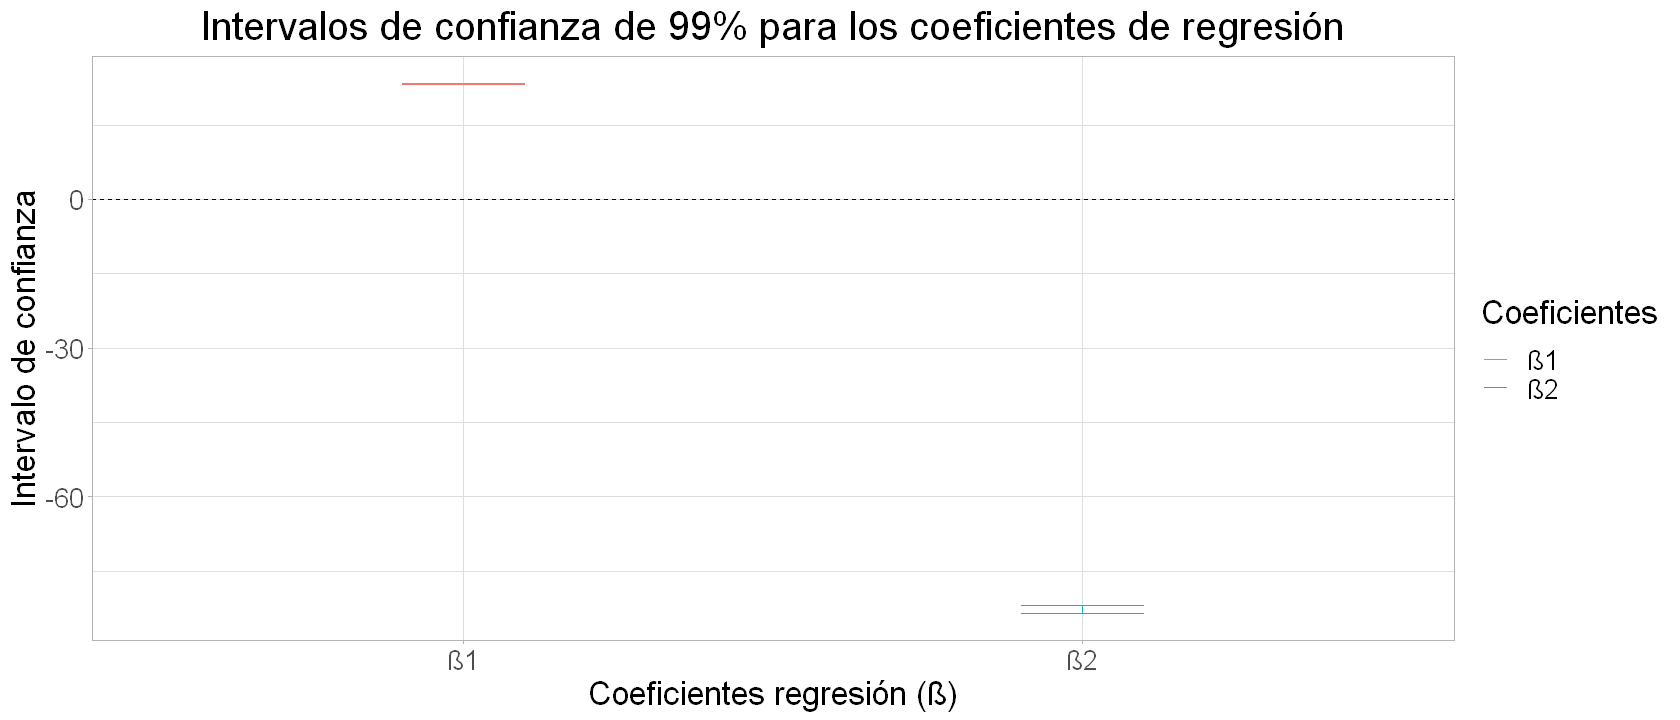

In [242]:
# Gráfico de los intervalos de confianza
options(repr.plot.width=14, repr.plot.height=6)
ggplot(conf_int, aes(coef, avg, colour=coef)) + 
    ggtitle("Intervalos de confianza de 99% para los coeficientes de regresión") +
    geom_errorbar(aes(ymin=lwr, ymax=upr), width = 0.2) +
    labs(x='Coeficientes regresión (β)', y='Intervalo de confianza', color='Coeficientes') +
    geom_hline(yintercept=0, linetype="dashed", col="black") +
    #scale_y_continuous(breaks=round(seq(min(conf_int) - 1, max(conf_int) + 1), 0)) +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

<div style="text-align: justify">Ninguno de los intervalos incluye al cero, y por lo tanto se rechazan las hipótesis $H_{0_1}: \beta_1 = 0$ y $H_{0_2}: \beta_2 = 0$.</div>

<br></br>

#### <div style="text-align: justify"><strong>c. Seis variables regresoras</strong></div>

<div style="text-align: justify">Por último, se propone un modelo que incluye las tensiones y corrientes, tanto directas como en cuadratura, y además incorpora los términos de interacción:</div>

<div style="text-align: justify; font-size: larger">$$y = \beta_0 + \beta_1 u_q + \beta_2 u_d + \beta_3 i_q + \beta_4 i_d + \beta_{13} u_q i_q + \beta_{24} u_d i_d$$</div>

In [190]:
model_speed.3 <- lm(motor_speed ~ u_q * i_q + u_d * i_d, pmsm_data.train)
summary(model_speed.3)


Call:
lm(formula = motor_speed ~ u_q * i_q + u_d * i_d, data = pmsm_data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2904.0  -229.7     9.2   232.1  3255.3 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.482e+02  2.678e+00  -55.34   <2e-16 ***
u_q          2.336e+01  3.566e-02  654.96   <2e-16 ***
i_q         -1.657e+00  3.032e-02  -54.65   <2e-16 ***
u_d         -8.275e+01  3.320e-01 -249.29   <2e-16 ***
i_d         -1.694e+01  2.818e-02 -601.27   <2e-16 ***
u_q:i_q     -5.720e-01  2.376e-03 -240.68   <2e-16 ***
u_d:i_d     -3.444e-01  1.568e-03 -219.65   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 420.7 on 93150 degrees of freedom
Multiple R-squared:  0.949,	Adjusted R-squared:  0.949 
F-statistic: 2.887e+05 on 6 and 93150 DF,  p-value: < 2.2e-16


<div style="text-align: justify">El $R^2$ de este modelo es $0.949$, lo cual indica que el ajute del modelo es particularmente bueno.</div>

In [234]:
conf_int <- confint(model_speed.3, c('u_q', 'u_d', 'i_q', 'i_d', 'u_q:i_q', 'u_d:i_d'), level = 0.99)

In [235]:
colnames(conf_int) <- c('lwr', 'upr')
conf_int <- data.frame(conf_int, avg=apply(conf_int, 1, mean), contiene_al_cero=ifelse(conf_int[,'lwr'] * conf_int[,'upr'] < 0, 'SI', 'NO'))
rownames(conf_int) <- c('β1', 'β2', 'β3', 'β4', 'β13', 'β24')
conf_int[c(1,3,2,4)]

,lwr,avg,upr,contiene_al_cero
,<dbl>,<dbl>,<dbl>,<chr>
ß1,23.2639979,23.3558542,23.4477106,NO
ß2,-83.6100361,-82.7549306,-81.8998251,NO
ß3,-1.7353602,-1.6572503,-1.5791404,NO
ß4,-17.0139869,-16.9414087,-16.8688305,NO
ß13,-0.5780763,-0.5719548,-0.5658333,NO
ß24,-0.3483970,-0.3443587,-0.3403203,NO


In [236]:
coef <- c('β1', 'β2', 'β3', 'β4', 'β13', 'β24')

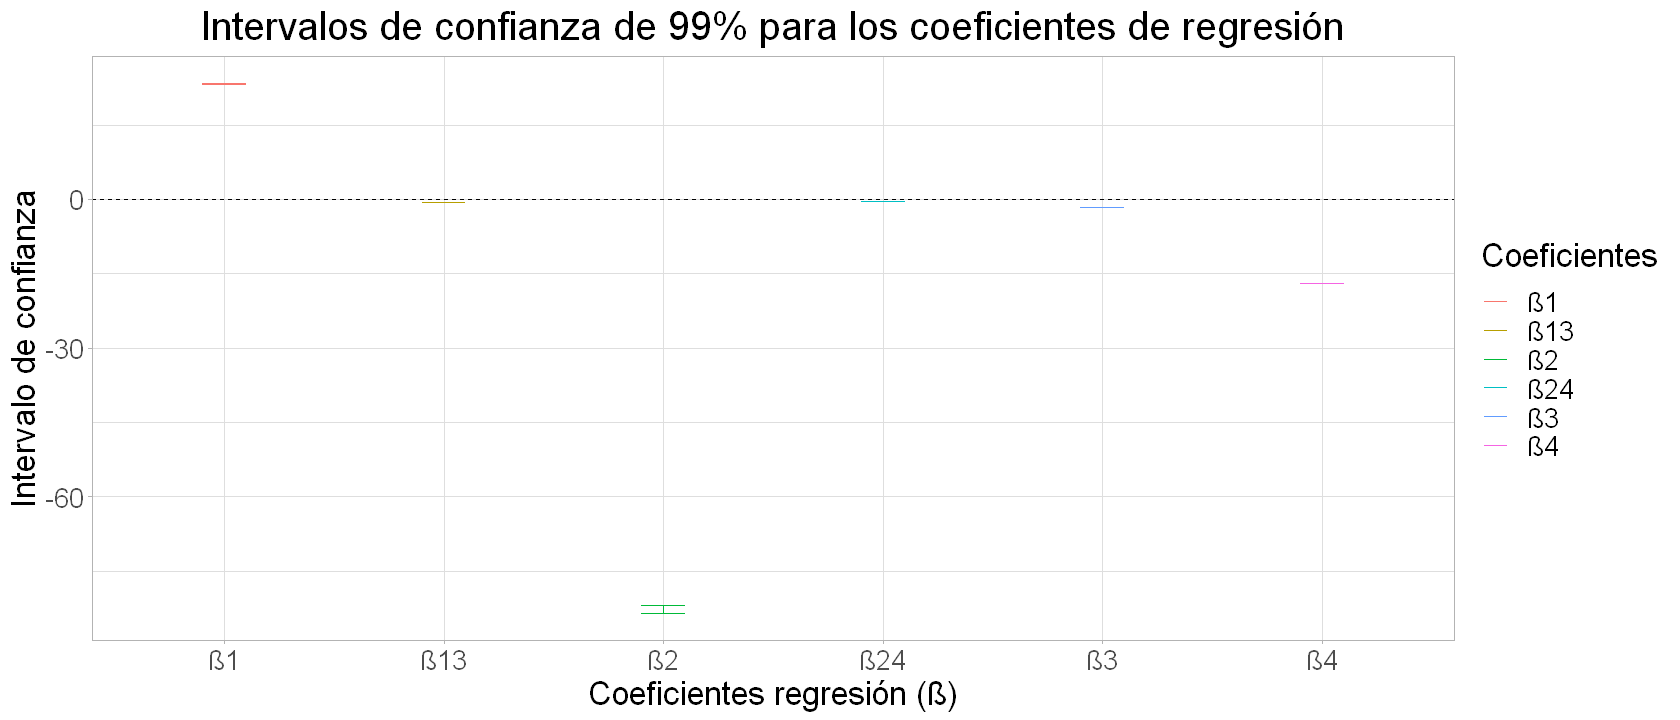

In [238]:
# Gráfico de los intervalos de confianza
options(repr.plot.width=14, repr.plot.height=6)
ggplot(conf_int, aes(coef, avg, colour=coef)) + 
    ggtitle("Intervalos de confianza de 99% para los coeficientes de regresión") +
    geom_errorbar(aes(ymin=lwr, ymax=upr), width = 0.2) +
    labs(x='Coeficientes regresión (β)', y='Intervalo de confianza', color='Coeficientes') +
    geom_hline(yintercept=0, linetype="dashed", col="black") +
    #scale_y_continuous(breaks=round(seq(min(conf_int) - 1, max(conf_int) + 1), 0)) +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

<div style="text-align: justify">Nuevamente, ninguno de los intervalos contiene al cero.</div>

<div style="text-align: justify"><strong>Residuos</strong></div>

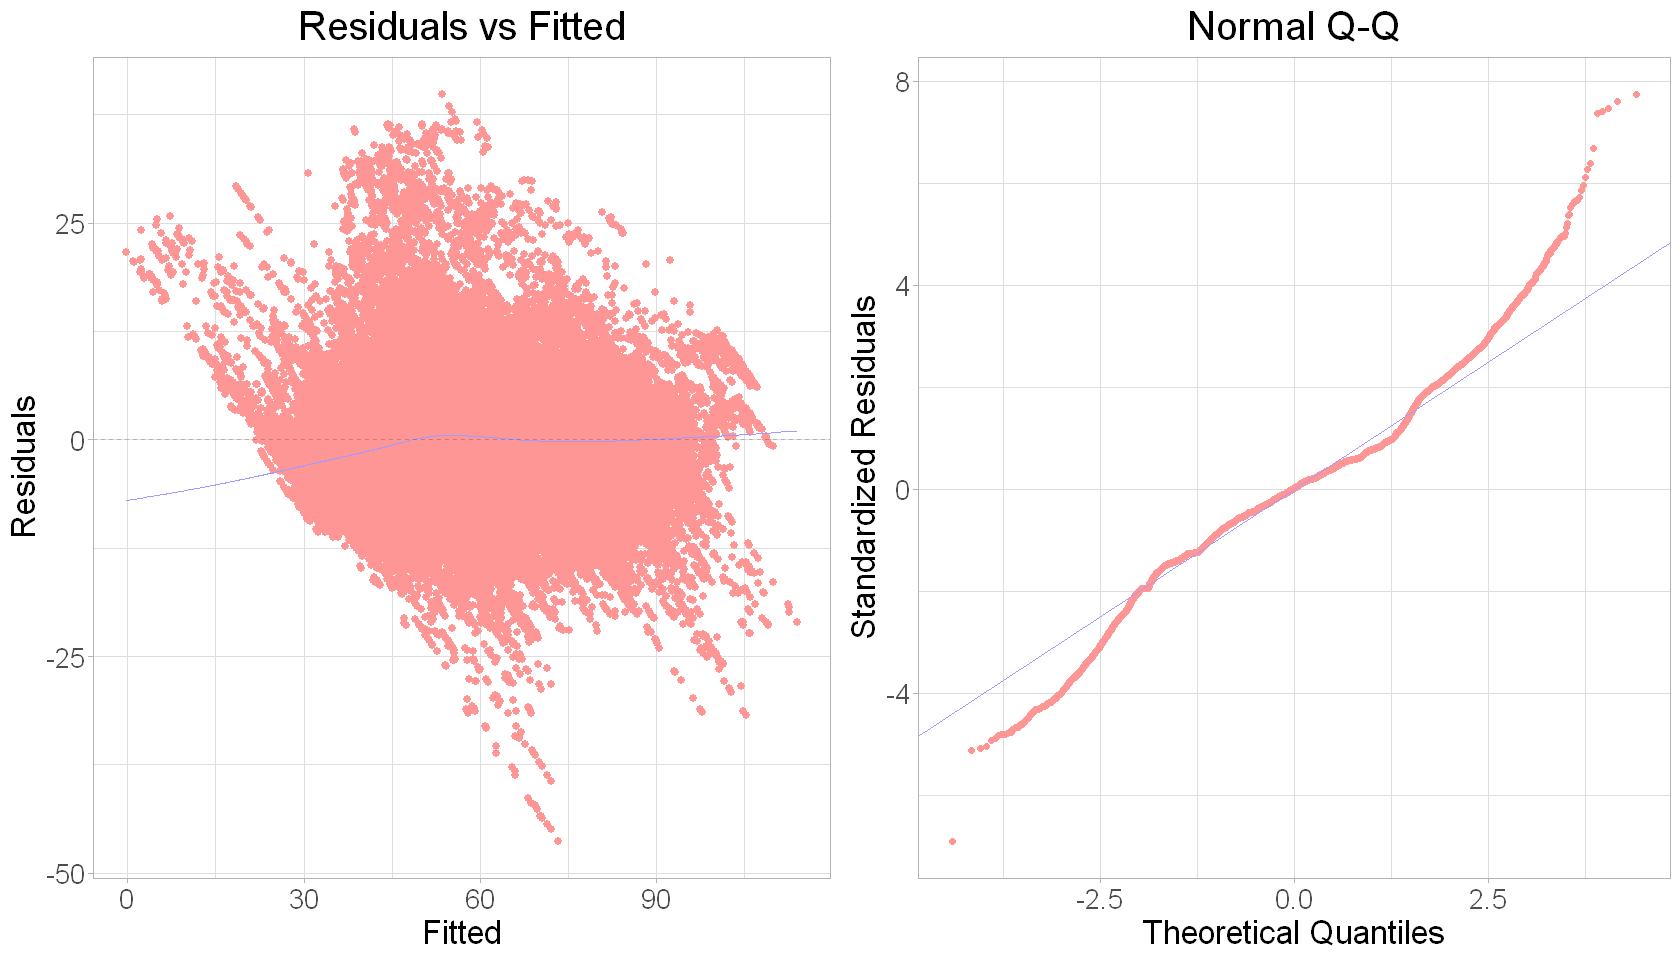

In [244]:
# Gráficos
options(repr.plot.width=14, repr.plot.height=8)
res_vs_fit <- ggplot(model_speed.3) + 
    geom_point(aes(x=model$fitted, y=model$residuals), color= '#ff9696', size=2) +
    geom_path(data = smoothed, aes(x = x, y = y), col="#a399ff") +
    geom_hline(linetype = 2, yintercept=0, alpha=0.2) +
    ggtitle("Residuals vs Fitted") +
    xlab("Fitted") +
    ylab("Residuals") +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

qq_plot <- ggplot(model_speed.3) +
    stat_qq(aes(sample = .stdresid), color= '#ff9696') +
    geom_abline(col="#a399ff") +
    xlab("Theoretical Quantiles") +
    ylab("Standardized Residuals") +
    ggtitle("Normal Q-Q") +
    theme_light() +
    theme(text=element_text(size=20),
     plot.title = element_text(size=24, hjust = 0.5))

plot_grid(res_vs_fit, qq_plot, ncol = 2)


<div style="text-align: justify"><b>Análisis de residuos</b></div>
<div style="text-align: justify">Los resultados son similares a los del modelo de predicción de temperatura:
    <ul>
        <li>La gráfica de <i style="color: blue">Residuos vs. Valores Ajustados</i> no presenta evidencias fuertes contra el supuesto de varianza constante.</li>
        <li>Los valores en la gráfica de <i style="color: red">Probabilidad Normal</i> presentan una forma de <b>S invertida</b>, lo cual sugiere que los datos provienen de una distribución que presenta mayor dispersión respecto de la distribución normal.</li>
    </ul>
</div>

***
<br></br>

<br></br>

## **Conclusiones**

<div style="text-align: justify">El monitoreo de los parámetros de funcionamiento de un motor es clave para detectar posibles fallos y defectos de maquinaria en las etapas incipientes y así evitar que estos se manifiesten, provocando situaciones de peligro y pérdidas económicas. Para ello es fundamental contar con un flujo constante de datos en tiempo real que permitan hacer diagnósticos con la mayor presición posible. Los modelos de regresión son una herramienta importante cuando se requiere estimar ciertos parámetros que resultan difíciles o costosos de medir en forma directa.</div>

<div style="text-align: justify">El análisis y precesamiento de grandes cantidades de datos, como en este caso, implica nuevas dificultades, sobre todo al momento de realizar operaciones complejas o visualizaciones gráficas. Si bien es posible trabajar con un subconjunto de los datos de forma tal que se reduzcan los tiempos de cómputo, se debe garantizar la aleatoriedad del muestreo para que los nuevos datos sean repesentativos de los originales.</div>

<div style="text-align: justify">Aunque los modelos de regresión lineal resultan últiles para representar diversos fenómenos, los supuestos que se deben cumplir para su validez restringen su campo de aplicación. En las secciones anteriores se puso en duda la normalidad de los datos estudiados, por lo que sería interesante explorar otros modelos predictivos que se ajusten mejor a la problemática planteada en este informe.</div>

***
<br></br>